In [230]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [231]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [232]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from sqlalchemy import and_

In [233]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [234]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [235]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [236]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [237]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [238]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date

'2017-08-23'

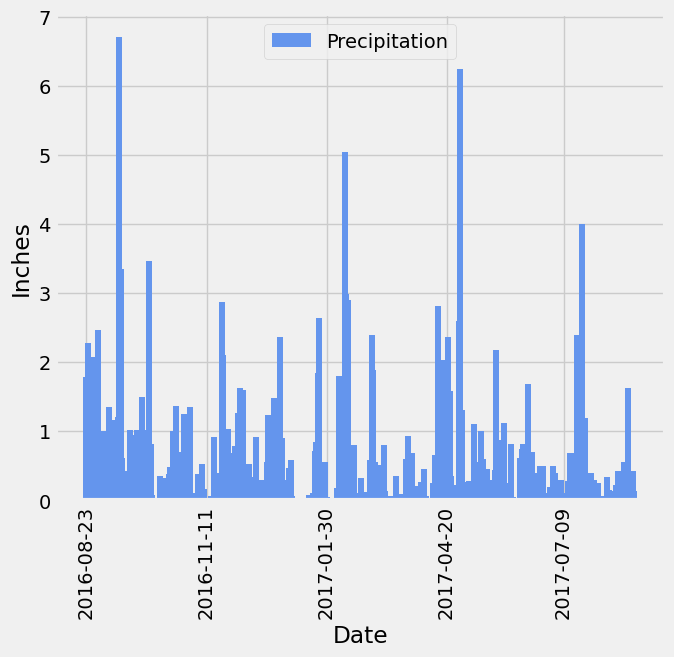

In [239]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
latest_date_obj = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()
one_year_ago = latest_date_obj - dt.timedelta(days=365)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(
    and_(Measurement.date >= one_year_ago, Measurement.date <= latest_date)
).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = [(result.date, result.prcp) for result in results]
last_12_df = pd.DataFrame(data, columns=['date', 'precipitation'])

# Sort the dataframe by date
dates_df = pd.DataFrame({'date': ['2016-08-23']})

# Calculate the specific dates that are approximately 80 days apart
for _ in range(4):
    last_date = pd.to_datetime(dates_df['date'].iloc[-1])
    new_date = last_date + pd.DateOffset(days=80)
    dates_df = pd.concat([dates_df, pd.DataFrame({'date': [new_date.strftime('%Y-%m-%d')]})], ignore_index=True)

specific_dates = dates_df['date'].tolist()

# Calculate the indices of the specific dates in the DataFrame
date_indices = [last_12_df.index[last_12_df['date'] == date].tolist()[0] for date in specific_dates]

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7, 6))
bars = plt.bar(last_12_df['date'], last_12_df["precipitation"], color='#6495ED', width=4, capstyle='round')
plt.xticks(date_indices, specific_dates, rotation="vertical")

plt.legend([bars], ['Precipitation'], loc='upper center')

plt.xlabel('Date')
plt.ylabel('Inches')

plt.show()



In [240]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = last_12_df["precipitation"].describe()

# Create a DataFrame for the summary statistics with the desired structure
summary_stats_df = pd.DataFrame(summary_stats.rename('Precipitation')).reset_index().rename(columns={'index': 'Statistics'})
summary_stats_df.set_index('Statistics', inplace=True)
summary_stats_df.index.name = None

summary_stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [241]:
# Design a query to calculate the total number of stations in the dataset
unique_station_count = session.query(func.count(Station.station)).distinct().scalar()

unique_station_count

9

In [242]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station).label('station_count')) \
                 .group_by(Measurement.station) \
                 .order_by(func.count(Measurement.station).desc()) \
                 .all()

# Print the results
for station in station_counts:
    print(station.station, station.station_count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [243]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
                       func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').one()
active_station_temps

(54.0, 85.0, 71.66378066378067)

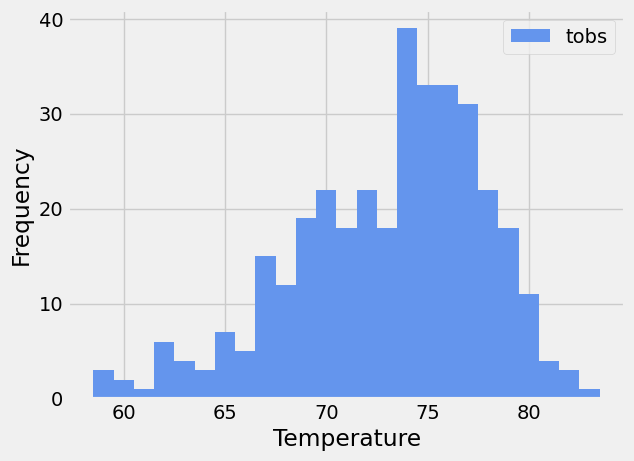

In [244]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_with_counts = session.query(Measurement.tobs, func.count(Measurement.tobs).label('temperature_count')) \
    .filter(and_(Measurement.date >= one_year_ago, Measurement.date <= latest_date, Measurement.station == 'USC00519281')) \
        .group_by(Measurement.tobs).order_by(func.count(Measurement.tobs).desc()).all()

results_with_counts_df = pd.DataFrame(results_with_counts, columns=['Temperature', 'Frequency'])
results_with_counts_df_ordered = results_with_counts_df.sort_values(by='Temperature', ascending=True)
#results_with_counts_df_ordered

bars = plt.bar(results_with_counts_df_ordered['Temperature'], results_with_counts_df_ordered["Frequency"], color='#6495ED', width=1, capstyle='round')

plt.yticks(range(0, max(results_with_counts_df_ordered["Frequency"]) + 10, 10))

plt.legend([bars], ['tobs'], loc='upper right')

plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.show()

# Close Session

In [245]:
# Close Session
session.close()